In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import vgg19, VGG19_Weights

In [2]:
content_img = Image.open("./notebook_images/face.jpg")

In [3]:
img_size = 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [4]:
content_tensor = transform(content_img)
content_tensor = content_tensor.unsqueeze(0)
print(f"content_tensor shape: {content_tensor.shape}")

content_tensor shape: torch.Size([1, 3, 128, 128])


In [5]:
noise_tensor = torch.randn((1, 3, 128, 128))
print(f"noise_tensor shape: {noise_tensor.shape}")

noise_tensor shape: torch.Size([1, 3, 128, 128])


In [6]:
untransform = transforms.Compose([
    transforms.ToPILImage(),
])

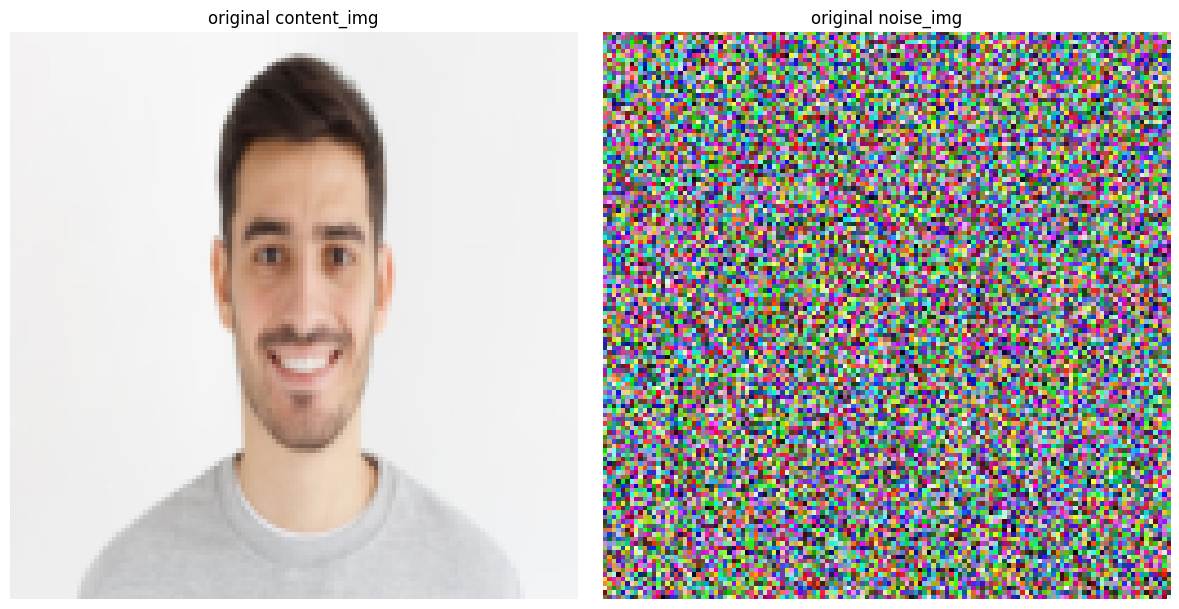

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(content_tensor.squeeze(0)))
plt.title("original content_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("original noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

model = nn.Sequential()
i = 0
for layer in vgg19_model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f'conv_{i}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu_{i}'
    elif isinstance(layer, nn.MaxPool2d):
        layer = nn.AvgPool2d(2, 2)
        name = f'pool_{i}'
    elif isinstance(layer, nn.BatchNorm2d):
        name = f'bn_{i}'
    
    model.add_module(name, layer)

    if name == f'conv_5':
        break

print(model)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU(inplace=True)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU(inplace=True)
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU(inplace=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU(inplace=True)
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
content_tensor_output = content_tensor.clone().to(device)
noise_tensor_output = noise_tensor.clone().to(device)

content_tensor_results = {}
noise_tensor_results = {}
for name, layer in model.named_children():
    with torch.no_grad():
        content_tensor_output.clamp_(0, 1)
        noise_tensor_output.clamp_(0, 1)

    content_tensor_output = layer(content_tensor_output)
    noise_tensor_output = layer(noise_tensor_output)

    content_tensor_results[name] = content_tensor_output
    noise_tensor_results[name] = noise_tensor_output

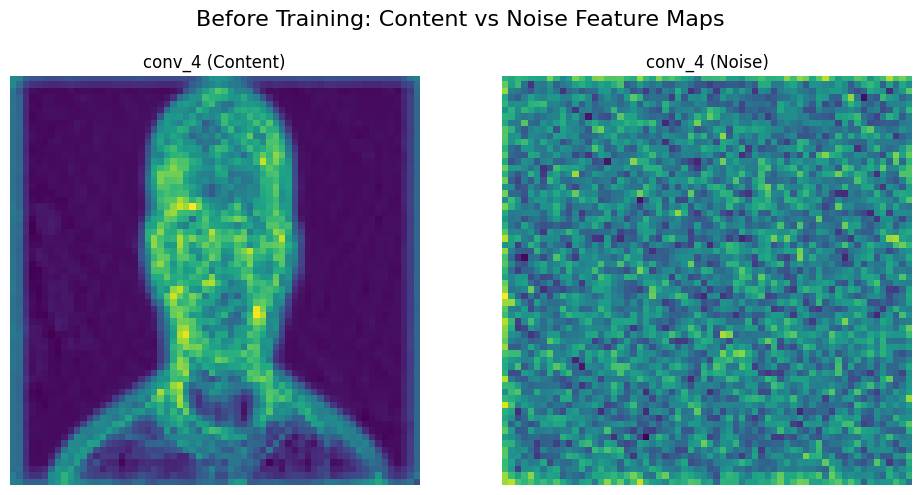

In [10]:
def visualize_feature_maps(content_results, noise_results, layers):
    fig, axes = plt.subplots(len(layers), 2, figsize=(10, 5 * len(layers)))
    fig.suptitle("Before Training: Content vs Noise Feature Maps", fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        content_feature_map = content_results[layer].squeeze(0).cpu()
        content_mean_map = torch.mean(content_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(content_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Content)")
        axes[i][0].axis("off")

        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(noise_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Noise)")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

layers_to_visualize = ["conv_4"]
visualize_feature_maps(content_tensor_results, noise_tensor_results, layers_to_visualize)

In [11]:
content_tensor_output = content_tensor.clone().to(device)
for name, layer in model.named_children():
    content_tensor_output = layer(content_tensor_output)
    if name == "conv_4":
        break
content_tensor_output = content_tensor_output.detach()

required_grad_noise_tensor = noise_tensor.clone().to(device)
required_grad_noise_tensor.requires_grad_(True)

criterion = nn.MSELoss()
optimizer = optim.SGD([required_grad_noise_tensor], lr=1)

epochs = 10000
for epoch in range(epochs):
    output_tensor = required_grad_noise_tensor
    with torch.no_grad():
        output_tensor.clamp_(0, 1) # replace

    optimizer.zero_grad()

    for name, layer in model.named_children():
        output_tensor = layer(output_tensor)
        
        if name == "conv_4":
            break

    loss = criterion(content_tensor_output, output_tensor)
    loss.backward()

    optimizer.step()

    if epoch % 50 == 0:
        print(f"{epoch}/{epochs} loss: {loss.item():.4f}")

    if loss == 0.0:
        print(f"Train finished")
        break

with torch.no_grad():
    output_tensor.clamp_(0, 1) # replace

0/10000 loss: 7.4320
50/10000 loss: 5.0816
100/10000 loss: 3.9001
150/10000 loss: 3.2071
200/10000 loss: 2.7439
250/10000 loss: 2.4037
300/10000 loss: 2.1372
350/10000 loss: 1.9203
400/10000 loss: 1.7357
450/10000 loss: 1.5740
500/10000 loss: 1.4293
550/10000 loss: 1.2976
600/10000 loss: 1.1771
650/10000 loss: 1.0670
700/10000 loss: 0.9666
750/10000 loss: 0.8745
800/10000 loss: 0.7883
850/10000 loss: 0.7067
900/10000 loss: 0.6277
950/10000 loss: 0.5497
1000/10000 loss: 0.4729
1050/10000 loss: 0.4028
1100/10000 loss: 0.3435
1150/10000 loss: 0.2977
1200/10000 loss: 0.2660
1250/10000 loss: 0.2444
1300/10000 loss: 0.2284
1350/10000 loss: 0.2156
1400/10000 loss: 0.2048
1450/10000 loss: 0.1956
1500/10000 loss: 0.1874
1550/10000 loss: 0.1802
1600/10000 loss: 0.1737
1650/10000 loss: 0.1678
1700/10000 loss: 0.1625
1750/10000 loss: 0.1576
1800/10000 loss: 0.1530
1850/10000 loss: 0.1487
1900/10000 loss: 0.1448
1950/10000 loss: 0.1411
2000/10000 loss: 0.1377
2050/10000 loss: 0.1344
2100/10000 loss

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

content_tensor_output = content_tensor.clone().to(device)
noise_tensor_output = required_grad_noise_tensor

content_tensor_results = {}
noise_tensor_results = {}
for name, layer in model.named_children():
    with torch.no_grad():
        content_tensor_output.clamp_(0, 1)
        noise_tensor_output.clamp_(0, 1)

    content_tensor_output = layer(content_tensor_output)
    noise_tensor_output = layer(noise_tensor_output)

    content_tensor_results[name] = content_tensor_output
    noise_tensor_results[name] = noise_tensor_output

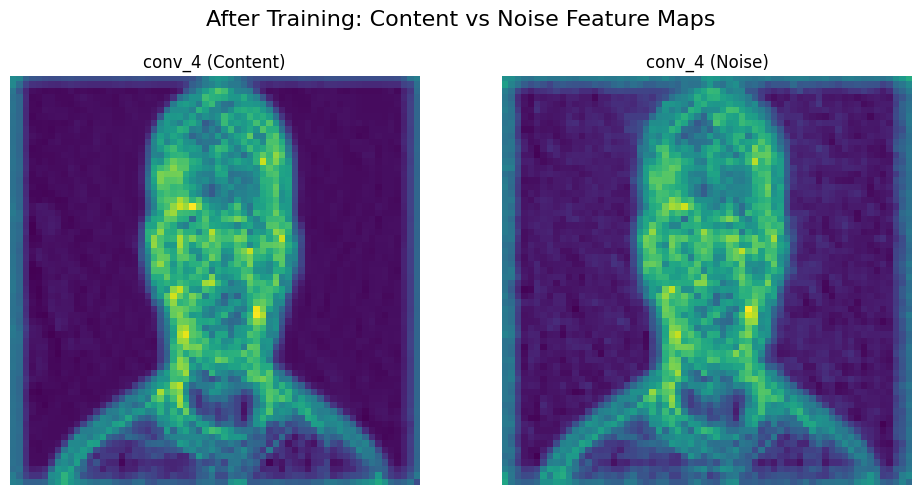

In [13]:
def visualize_feature_maps(content_results, noise_results, layers):
    fig, axes = plt.subplots(len(layers), 2, figsize=(10, 5 * len(layers)))
    fig.suptitle("After Training: Content vs Noise Feature Maps", fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        content_feature_map = content_results[layer].squeeze(0).cpu()
        content_mean_map = torch.mean(content_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(content_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Content)")
        axes[i][0].axis("off")

        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(noise_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Noise)")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

layers_to_visualize = ["conv_4"]
visualize_feature_maps(content_tensor_results, noise_tensor_results, layers_to_visualize)

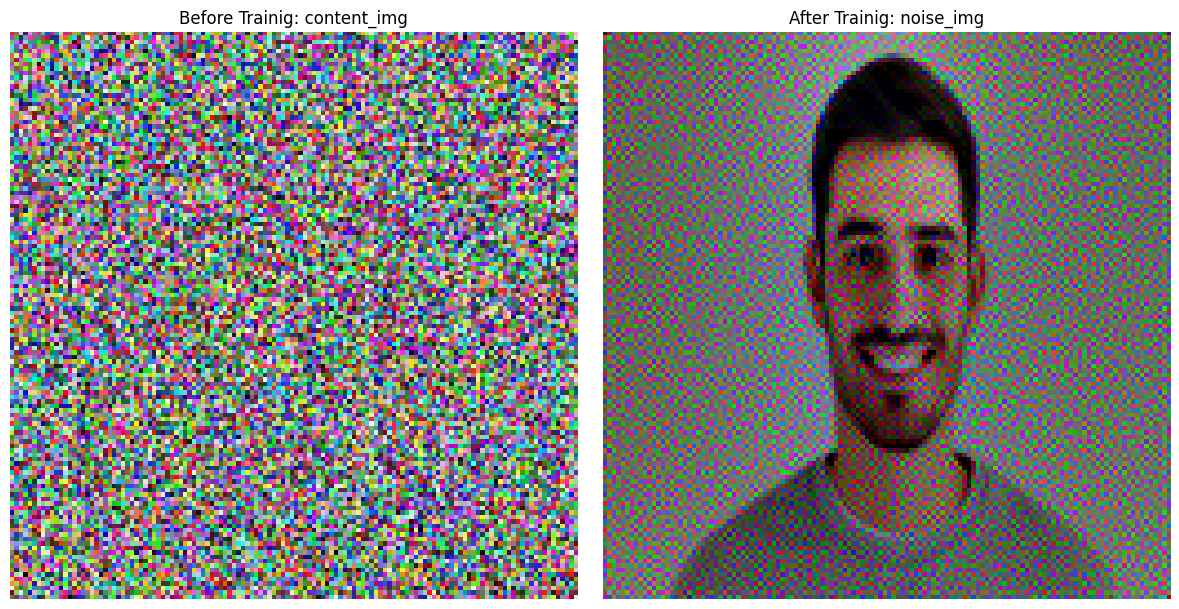

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("Before Trainig: content_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(required_grad_noise_tensor.squeeze(0)))
plt.title("After Trainig: noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()